## Comparison of CAI, tAI and modelled translation efficiencies

In [1]:
import os
import os.path
import cPickle as pkl
import matplotlib
matplotlib.use("pgf")
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [u'Adobe Caslon Pro'], # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"],  # use a specific sans-serif font
    'axes.labelsize': '16',
}
matplotlib.rcParams.update(pgf_with_rc_fonts)
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.insert(0, '/home/martin/tAI-master')

In [3]:
from Bio import SeqIO
from statsmodels.nonparametric.smoothers_lowess import lowess

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

### tRNA adaptation index (tAI)

From https://github.com/smsaladi/tAI:

In [4]:
import tAI

In [5]:
print dir(tAI)

['__all__', '__builtins__', '__doc__', '__file__', '__name__', '__package__', '__path__', 'tAI']


In [6]:
tRNA_types = {
    1: {'anticodon': 'ugc', 'abundancy': 55351},  # reverse complement the anticodon to look it up
    2: {'anticodon': 'agc', 'abundancy': 121771},
    3: {'anticodon': 'ucu', 'abundancy': 121771},
    4: {'anticodon': 'ccu', 'abundancy': 11070},
    5: {'anticodon': 'ccg', 'abundancy': 11070},
    6: {'anticodon': 'acg', 'abundancy': 66421},
    7: {'anticodon': 'guu', 'abundancy': 110701},
    8: {'anticodon': 'guc', 'abundancy': 177122},
    9: {'anticodon': 'gca', 'abundancy': 44280},
    10: {'anticodon': 'uug', 'abundancy': 88561},
    11: {'anticodon': 'cug', 'abundancy': 11070},
    12: {'anticodon': 'uuc', 'abundancy': 154982},
    13: {'anticodon': 'ucc', 'abundancy': 33210},
    14: {'anticodon': 'ccc', 'abundancy': 22140},
    15: {'anticodon': 'gcc', 'abundancy': 177122},
    16: {'anticodon': 'gug', 'abundancy': 77491},
    17: {'anticodon': 'uau', 'abundancy': 22140},
    18: {'anticodon': 'aau', 'abundancy': 143911},
    19: {'anticodon': 'uag', 'abundancy': 33210},
    20: {'anticodon': 'gag', 'abundancy': 11070},
    21: {'anticodon': 'uaa', 'abundancy': 77491},
    22: {'anticodon': 'caa', 'abundancy': 110701},
    23: {'anticodon': 'uuu', 'abundancy': 77491},
    24: {'anticodon': 'cuu', 'abundancy': 154982},
    25: {'anticodon': 'cau', 'abundancy': 55351},  # 26 does not seem to exist
    27: {'anticodon': 'gaa', 'abundancy': 110701},
    28: {'anticodon': 'agg', 'abundancy': 22140},
    29: {'anticodon': 'ugg', 'abundancy': 110701},
    30: {'anticodon': 'gcu', 'abundancy': 33210},
    31: {'anticodon': 'uga', 'abundancy': 33210},
    32: {'anticodon': 'aga', 'abundancy': 121771},
    33: {'anticodon': 'cga', 'abundancy': 11070},
    34: {'anticodon': 'ugu', 'abundancy': 44280},
    35: {'anticodon': 'agu', 'abundancy': 121771},
    36: {'anticodon': 'cgu', 'abundancy': 11070},
    37: {'anticodon': 'cca', 'abundancy': 66421},
    38: {'anticodon': 'gua', 'abundancy': 88561},
    39: {'anticodon': 'uac', 'abundancy': 22140},
    40: {'anticodon': 'aac', 'abundancy': 154982},
    41: {'anticodon': 'cac', 'abundancy': 22140},
    42: {'anticodon': '*', 'abundancy': 18000},  # termination factor
    43: {'anticodon': 'cuc', 'abundancy': 22140}
}

In [7]:
bases = list('acgu')

codons = [a + b + c for a in bases for b in bases for c in bases]

Reverse complement:

In [8]:
def complement(s):
    ''' complementary RNA'''
    basecomplement = {'a': 'u', 'c': 'g', 'g': 'c', 'u': 'a'}
    letters = list(s)
    letters = [basecomplement[base] for base in letters]
    return ''.join(letters)

def revcom(s):
    ''' reverse complementary RNA'''
    if s == "*":
        return False
    return complement(s[::-1])

From https://github.com/gittenberg/TRSL/blob/master/workbooks/analyses/03%20TRSL_check_observables.ipynb:

In [9]:
anticodon_tRNA_abundancy = {tRNA_types[id]['anticodon']: tRNA_types[id]['abundancy'] for id in tRNA_types}

In [10]:
codon_tRNA_abundancy = {codon: anticodon_tRNA_abundancy[revcom(codon)] if revcom(codon) in 
                        anticodon_tRNA_abundancy else 0 for codon in codons} 

Delete stop codons:

In [11]:
del codon_tRNA_abundancy['uaa']
del codon_tRNA_abundancy['uga']
del codon_tRNA_abundancy['uag']

In [12]:
orfs = pkl.load(open("../../parameters/orf_coding.p", "rb"))

Test case (SWI5, YDR146C):

In [13]:
nucseq = orfs['YDR146C']
nucseq[:60]

'auggauacaucaaacucuugguuugaugccucaaaaguacaaagccuaaauuuugaccua'

In [14]:
codon_tRNA_abundancy_series = pd.Series({key.upper().replace('U', 'T'): codon_tRNA_abundancy[key] 
                                         for key in codon_tRNA_abundancy})

In [15]:
codon_tRNA_abundancy_series

AAA     77491
AAC    110701
AAG    154982
AAT         0
ACA     44280
ACC         0
ACG     11070
ACT    121771
AGA    121771
AGC     33210
AGG     11070
AGT         0
ATA     22140
ATC         0
ATG     55351
ATT    143911
CAA     88561
CAC     77491
CAG     11070
CAT         0
CCA    110701
CCC         0
CCG         0
CCT     22140
CGA         0
CGC         0
CGG     11070
CGT     66421
CTA     33210
CTC     11070
        ...  
CTT         0
GAA    154982
GAC    177122
GAG     22140
GAT         0
GCA     55351
GCC         0
GCG         0
GCT    121771
GGA     33210
GGC    177122
GGG     22140
GGT         0
GTA     22140
GTC         0
GTG     22140
GTT    154982
TAC     88561
TAT         0
TCA     33210
TCC         0
TCG     11070
TCT    121771
TGC     44280
TGG     66421
TGT         0
TTA     77491
TTC    110701
TTG    110701
TTT         0
dtype: int64

### Calculate using tAI from Python and Chu tRNA abundancies
<a id='tai_python'></a>

In [16]:
my_tAI = tAI.tAI(trna_count=codon_tRNA_abundancy_series, bacteria=False)

Time-consuming step (~1 min): actual calculation:

In [17]:
tAI_dict_python_chu = {}

for orf in orfs:
    tAI_dict_python_chu[orf] = my_tAI.calc(orfs[orf])

### Calculate using tAI from R (Chu et al. data)

Import tAIs from R:

In [18]:
with open('/home/martin/git/TRSL/workbooks/analyses/tAI_misc/yeast.json','r') as inf:
    tAI_dict_R_Chu = eval(inf.read())

In [19]:
tAI_dict_R_Chu['YDR146C']

0.37115

### Calculate using tAI from Python and gtRNAdb (http://gtrnadb.ucsc.edu/genomes/eukaryota/Scere3/)

In [20]:
rootdir = os.getcwd()
datadir = os.path.join(os.getcwd(), "tAI-master/test/data")

In [21]:
tAI_dict_python_from_gtrnadb = {}

my_tai = tAI.tAI.from_gtRNAdb(os.path.join(datadir, r"sacCer3-tRNAs.bed"))

In [22]:
print my_tai.weights.head()

GCA   -1.177819
GTA   -2.093630
AAG    0.000000
AAA   -0.841567
ACG   -1.963302
Name: ln_weights, dtype: float64


In [23]:
for r in orfs:
    tAI_dict_python_from_gtrnadb[r] = my_tai.calc(orfs[r])

In [24]:
myedgecolor = 'steelblue'
myfacecolor = 'steelblue'

In [25]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None, markersize=20,
                  alpha=0.8, xlog=True, ylog=True, xmax=False, ymax=False, rasterized=True):
    #, filename="scatterdict.png"):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    #fig =  plt.figure(figsize=figsize)                

    #ax = fig.add_subplot(111)
    #ax.set_rasterization_zorder(1)
    
    ax.grid(True, linestyle = '-', color = '0.75')
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    if xmax:
        ax.set_xlim(right=xmax)
    if ymax:
        ax.set_ylim(top=ymax)

    scat = plt.scatter(xs, ys,
                       #c=plt.rcParams['axes.color_cycle'][0], 
                       c=myfacecolor, 
                       #edgecolor=plt.rcParams['patch.edgecolor'],
                       edgecolor=myedgecolor,
                       s=markersize, zorder=0)
    scat.set_alpha(alpha)
    #scat.set_color()
    #scat.set_edgecolors(plt.rcParams['patch.edgecolor'])
    # , color=, edgecolor=

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points][:-2]  # modify to remove outliers 
    new_ys = [point[1] for point in sorted_points][:-2]  # modify to remove outliers
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, 'darkred', linewidth=4)

    ax.set_rasterization_zorder(1)

5917


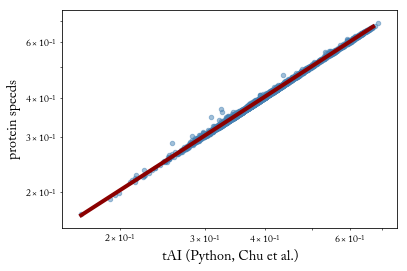

In [26]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(tAI_dict_python_chu, tAI_dict_R_Chu, xaxislabel="tAI (Python, Chu et al.)", yaxislabel="protein speeds",
              fontsize=14, alpha=0.5, xlog=True, ylog=True, xmax=False, ymax=False)

5917


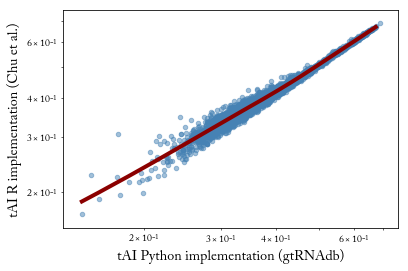

In [27]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(tAI_dict_python_from_gtrnadb, tAI_dict_R_Chu, xaxislabel="tAI Python implementation (gtRNAdb)", 
              yaxislabel="tAI R implementation (Chu et al.)", fontsize=14, alpha=0.5, xlog=True, ylog=True, xmax=False, ymax=False)

In [28]:
pd.Series(tAI_dict_python_chu).describe()

count    6713.000000
mean        0.379042
std         0.069379
min         0.166043
25%         0.342188
50%         0.367924
75%         0.402683
max         0.688188
dtype: float64

In [29]:
pd.Series(tAI_dict_python_from_gtrnadb).describe()

count    6713.000000
mean        0.358015
std         0.076301
min         0.141384
25%         0.314824
50%         0.344046
75%         0.384546
max         0.688190
dtype: float64

In [30]:
pd.Series(tAI_dict_R_Chu).describe()

count    5917.000000
mean        0.391639
std         0.066712
min         0.170230
25%         0.353030
50%         0.376540
75%         0.412410
max         0.688190
dtype: float64

We will use tAI_dict_python_chu due to better coverage and identity (where available) to Python implementation.

## New section (good name?)

We look at the time-unresolved simulation.

In [31]:
filepath = "../../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20170831_1936_200000_ribosomes_3600s.p"

Time-consuming step (< 2 min): load results:

In [32]:
results = pkl.load(open(filepath))

In [33]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein', 
             'peptide_bonds']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

#### A. Protein speeds including the initiation event (the correlation to tAI might be weaker here):

In [34]:
prot_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # 599 to exclude the "burn in" phase
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * results['timerange'][stop] - results['timerange'][start])
    # print only the fastest
    if prot_speeds[prot] > 100: 
        print prot, prot_speeds[prot]

YKL060C 145.05603770336145
YAL038W 123.39042473709229
YJL189W 115.2008620690014
YCR012W 112.4130697166854
YOL086C 117.78119432154942
YLR110C 108.38160919543606
YLR044C 193.69072935232197
YKL152C 115.51755848040843


These are proteins per second per cell (including of course the initiation event).

In [35]:
pd.Series(prot_speeds.values()).describe()

count    4475.000000
mean        1.349097
std         7.842725
min         0.000287
25%         0.048851
50%         0.123851
75%         0.378315
max       193.690729
dtype: float64

4475


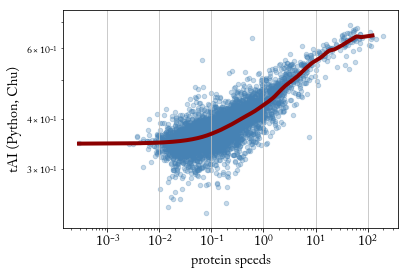

In [36]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(prot_speeds, tAI_dict_python_chu, xaxislabel="protein speeds", yaxislabel="tAI (Python, Chu)", 
              fontsize=14, alpha=0.3, xlog=True, ylog=True, xmax=False, ymax=False)

4475


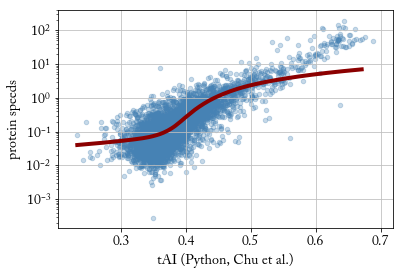

In [37]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(tAI_dict_python_chu, prot_speeds, xaxislabel="tAI (Python, Chu et al.)", yaxislabel="protein speeds",
              fontsize=14, alpha=0.3, xlog=False, ylog=True, xmax=False, ymax=False)

Note that ```prot_speeds``` does contain the mRNA abundance because it counts total number of synthesized protein molecules per time.

Not a perfect fit but this is probably because the initiation probability and the transcript count still overlay the tAI.

#### B. Protein speeds NOT including the initiation event (the correlation to tAI might be stronger here):

We are using the method at https://github.com/gittenberg/TRSL/blob/master/workbooks/analyses/03%20TRSL_check_observables.ipynb.

Get the tic_tocs:

In [38]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

The index is just the number of the transcript, not its gene ID.

In [39]:
len(transcript_tic_toc)

57508

One transcript is transcribed many times. (Overlapping times are not considered.)

In [40]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]])
                               for index in transcript_tic_toc}

/home/martin/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/martin/.local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [41]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [42]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [43]:
transcript_df.tail()

,tic_toc
57503,26.532075
57504,27.083019
57505,26.735780
57506,26.775472
57507,26.961538


In [44]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [45]:
temp_df.tail()

,geneID
57503,YLR192C
57504,YLR192C
57505,YLR192C
57506,YLR192C
57507,YLR192C


In [46]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [47]:
transcript_df.tail()

,tic_toc,geneID
57503,26.532075,YLR192C
57504,27.083019,YLR192C
57505,26.735780,YLR192C
57506,26.775472,YLR192C
57507,26.961538,YLR192C


In [48]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic toc [s]']

In [49]:
gene_tic_toc_df.tail()

,name,tic toc [s]
4470,YJL081C,71.884435
4471,YMR127C,60.685714
4472,YPL013C,19.936467
4473,YLR440C,97.862222
4474,YLR192C,26.893313


So the tic toc [s] is the mean time to produce a protein by geneID. As such it is already normalized by transcript count.

In [50]:
orf_lengths = {prot: len(orfs[prot]) for prot in orfs}

In [51]:
pd.Series(orf_lengths.values()).describe()

count     6713.000000
mean      1352.414122
std       1139.682772
min         51.000000
25%        534.000000
50%       1077.000000
75%       1767.000000
max      14733.000000
dtype: float64

Still the same (check).

In [52]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'ORF length [nts]']

In [53]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

In [54]:
gene_tic_toc_df.set_index('name')

,tic toc [s]
name,
YBR177C,59.901247
YIL140W,100.371746
YLR268W,33.104739
YOR011W,214.940000
YPL043W,75.186086
YJL155C,62.200000
YLL062C,47.686275
YHR067W,51.702703
YAL008W,29.178178


In [55]:
gene_tic_toc_dict = dict(zip(gene_tic_toc_df.name, gene_tic_toc_df['tic toc [s]']))

In [56]:
pkl.dump(gene_tic_toc_dict, open("../../parameters/gene_tic_toc_dict.p", "wb"))

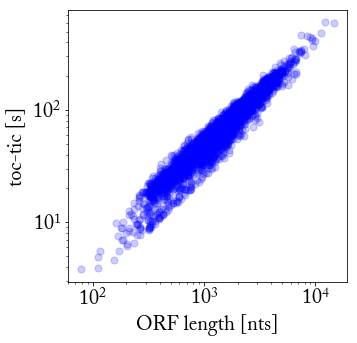

In [57]:
fig = plt.figure(figsize=(5, 5))

ax = plt.gca()
ax.scatter(df['ORF length [nts]'], df['tic toc [s]'], alpha=0.2, s=50, color='b')

ax.set_xlabel('ORF length [nts]', fontsize=20)
ax.set_ylabel('toc-tic [s]', fontsize=20)

plt.setp(plt.gca().get_xticklabels(), fontsize=20)
plt.setp(plt.gca().get_yticklabels(), fontsize=20)

ax.set_yscale('log')
ax.set_xscale('log')

In [58]:
df['Speed'] = df['ORF length [nts]'] / df['tic toc [s]']

In [59]:
df.dropna(how='any', inplace=True)

In [60]:
df.tail()

,name,tic toc [s],ORF length [nts],Speed
4470,YJL081C,71.884435,1470,20.449490
4471,YMR127C,60.685714,1017,16.758475
4472,YPL013C,19.936467,366,18.358318
4473,YLR440C,97.862222,2130,21.765294
4474,YLR192C,26.893313,798,29.672804


In [61]:
df['Speed'].describe()

count    4475.000000
mean       21.675455
std         3.970934
min        12.443551
25%        19.094572
50%        21.032899
75%        23.287783
max        40.893672
Name: Speed, dtype: float64

So the actual speeds are less variable ($21.7 \pm 4.0$ nts per second).

The variance can likely be explained by tAI.

In [62]:
tic_toc_speed_dict = dict(zip(df['name'] , df['Speed']))

Semilogarithmic plot:

4475


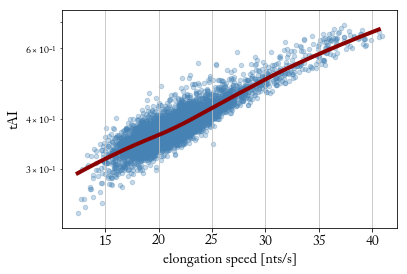

In [63]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(tic_toc_speed_dict, tAI_dict_python_chu, "elongation speed [nts/s]", "tAI",
              fontsize=14, alpha=0.3, xlog=False, ylog=True, xmax=False, ymax=False)

Inverted and linearly plotted:

4475


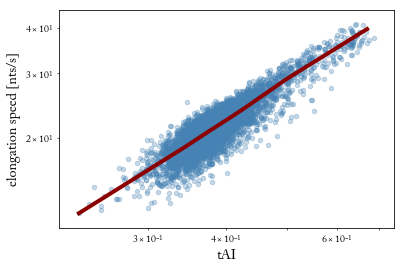

In [64]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(tAI_dict_python_chu, tic_toc_speed_dict, "tAI",  "elongation speed [nts/s]", 
             fontsize=14, alpha=0.3, xlog=True, ylog=True, xmax=False, ymax=False)

Beautiful dependence of tic-toc speeds on tRNA adaptation.

#### C. Like A, but divided by transcript count

In [65]:
transcriptome = pkl.load(open("../../parameters/transcriptome_shah.p", "rb"))

In [66]:
transcriptome_df = pd.DataFrame.from_dict(transcriptome, orient='index', dtype=None)
print len(transcriptome_df)

4839


In [67]:
prot_speeds_df = pd.DataFrame.from_dict(prot_speeds, orient='index', dtype=None)
print len(prot_speeds_df)

4475


In [68]:
prot_speeds_df.tail()

,0
YMR127C,0.022414
YPL013C,0.318984
YJR067C,0.173861
YHR083W,0.131897
YMR184W,0.242830


This is proteins per second per cell including the initiation event. In a way this is the Holy Grail which we want to model.

In [69]:
total_df = pd.merge(transcriptome_df, prot_speeds_df, left_index=True, right_index=True, how='outer')
print len(total_df)

4839


In [70]:
total_df.columns = ['transcripts', 'prot_speeds']

In [71]:
total_df['prot_speed_per_transcript'] = total_df['prot_speeds'] / total_df['transcripts']
total_df.dropna(how='any', inplace=True)

In [72]:
total_df.head()

,transcripts,prot_speeds,prot_speed_per_transcript
YAL001C,2,0.039083,0.019541
YAL002W,1,0.010920,0.010920
YAL003W,322,53.933559,0.167496
YAL007C,14,0.879074,0.062791
YAL008W,3,0.257199,0.085733


The right hand side is proteins per second per transcript including the initiation event.

Let's get everything into one dataframe:

In [73]:
df = pd.merge(df, total_df, how='outer', left_on=['name'], right_index=True)

In [74]:
prot_speed_per_transcript_dict = dict(zip(total_df.index, total_df['prot_speed_per_transcript']))

4475


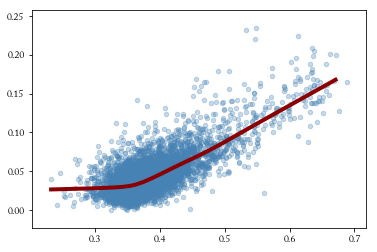

In [75]:
scatter_dicts(tAI_dict_python_chu, prot_speed_per_transcript_dict, "tAI",  "protein speeds per transcript", 
    fontsize=14, alpha=0.3, xlog=False, ylog=True, xmax=False, ymax=False)

Interesting. So there is some residual dependency which is not yet captured by tAI alone.

It is probably the initiation probability - let's try.

In [76]:
initiation_rates = pkl.load(open("../../parameters/init_rates_plotkin.p"))

In [77]:
pd.Series(initiation_rates.values()).describe()

count    4.839000e+03
mean     1.567727e-06
std      1.128263e-06
min      9.375766e-10
25%      8.320521e-07
50%      1.291872e-06
75%      1.962904e-06
max      1.440641e-05
dtype: float64

4475


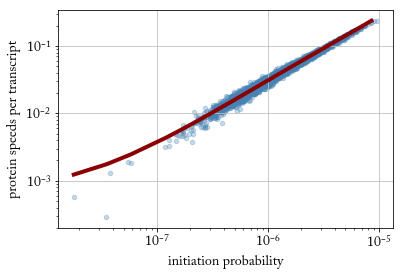

In [78]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(initiation_rates, prot_speed_per_transcript_dict, xaxislabel="initiation probability", 
              yaxislabel="protein speeds per transcript",
              fontsize=14, alpha=0.3, xlog=True, ylog=True, xmax=False, ymax=False)

So $p_I$ predicts the protein speed per transcript almost entirely, but tAI predicts the time after initiation almost entirely.

4716


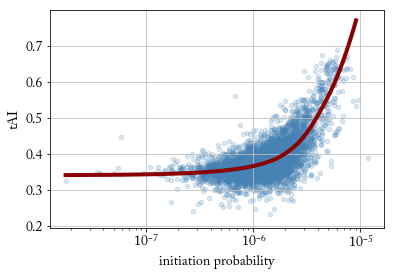

In [79]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(initiation_rates, tAI_dict_python_chu, xaxislabel="initiation probability", 
              yaxislabel="tAI",
              fontsize=14, alpha=0.2, xlog=True, ylog=False, xmax=False, ymax=False)

There is also a connection between $p_I$ and tAI.

Interesting - $p_I$ depends on upstream code, while tAI depends on in-ORF code but they are related, maybe indirectly through transcript abundance.

| initiation probability | speed of initiation | codon adaptation | speed of elongation |
|----------|----------|----------|----------|
| high $p_I$ | quick initiation | high tAI | fast elongation | 
| low $p_I$  | slow initiation | low tAI  | slow elongation |

So the initiation and the elongation go in the same direction which makes sense. (Evolution has used all available means to regulate translation.)

But also once the (rate-limiting!) ribosome is on a ``slow`` ORF, it is not available for other ORFs any more. Resources (ATP, GTP, other?) are therefore diverted away from the non-critical genes towards the critical (because regulatory) genes.

4475


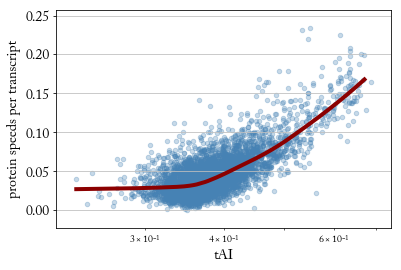

In [80]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(tAI_dict_python_chu, prot_speed_per_transcript_dict, "tAI",  "protein speeds per transcript", 
              fontsize=14, alpha=0.3, xlog=True, ylog=False, xmax=False, ymax=False)

4716


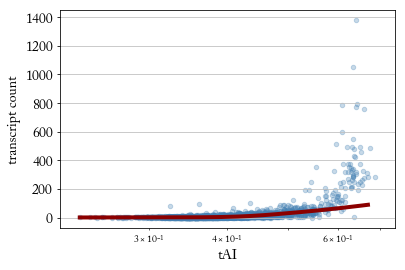

In [81]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(tAI_dict_python_chu, transcriptome, "tAI",  "transcript count", 
              fontsize=14, alpha=0.3, xlog=True, ylog=False, xmax=False, ymax=False)

Weird. Inverted:

4716


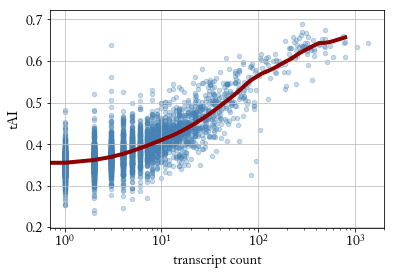

In [82]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(transcriptome, tAI_dict_python_chu, "transcript count", "tAI",
              fontsize=14, alpha=0.3, xlog=True, ylog=False, xmax=False, ymax=False)

Wow. Cut x axis:

Genes with low expression have lower tAI. (They are more strongly regulated which is partially achieved by codon usage.) This is not a model result!

In [83]:
pkl.dump(tAI_dict_python_chu, open("../../parameters/tAI_python_chu.p", "wb"))

pkl.dump(prot_speeds, open("../../parameters/prot_speeds.p", "wb"))
pkl.dump(tic_toc_speed_dict, open("../../parameters/tic_toc_speed_dict.p", "wb"))
pkl.dump(prot_speed_per_transcript_dict, open("../../parameters/prot_speed_per_transcript_dict.p", "wb"))

### Actual versus predicted

We build a simple model for protein synthesis rates à la

$$\mathrm{synthesis\ rate}_i = f(p_{I, i}) \cdot \mathrm{transcripts}_i$$

and then we compare actual and predicted. We can do the same for Arava et al. (2003) data. So now we parameterise $f$.

In [84]:
tAI_df = pd.Series(tAI_dict_python_chu, name='tAI').to_frame()
tAI_df.tail()

,tAI
YPR201W,0.369256
YPR202W,0.350602
YPR203W,0.321419
YPR204C-A,0.252857
YPR204W,0.344408


In [85]:
df_with_tAI = pd.merge(df, tAI_df, how='inner', left_on=['name'], right_index=True)

In [86]:
initiation_rates_df = pd.DataFrame(initiation_rates.items(), columns=['name', 'p_init'])

In [87]:
regression_data = pd.merge(df_with_tAI, initiation_rates_df, how='inner', left_on=['name'], right_on=['name'])

In [88]:
regression_data.tail()

,name,tic toc [s],ORF length [nts],Speed,transcripts,prot_speeds,prot_speed_per_transcript,tAI,p_init
4470,YJL081C,71.884435,1470,20.449490,5,0.150287,0.030057,0.375582,9.111658e-07
4471,YMR127C,60.685714,1017,16.758475,1,0.022414,0.022414,0.323240,5.499448e-07
4472,YPL013C,19.936467,366,18.358318,5,0.318984,0.063797,0.308066,2.289991e-06
4473,YLR440C,97.862222,2130,21.765294,2,0.072126,0.036063,0.368466,1.186173e-06
4474,YLR192C,26.893313,798,29.672804,22,2.742112,0.124641,0.510948,4.290874e-06


Drop NAs:

In [89]:
regression_data = regression_data[~regression_data.isnull().any(axis=1)]
len(regression_data)

4475

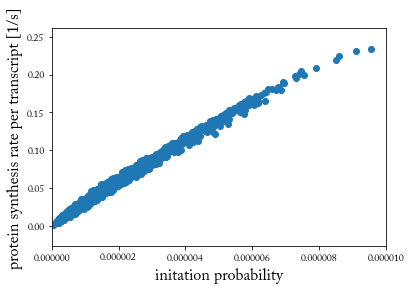

In [90]:
ax = plt.scatter(regression_data['p_init'], regression_data['prot_speed_per_transcript'])
plt.xlim(0, 0.00001)
plt.xlabel('initation probability')
plt.ylabel('protein synthesis rate per transcript [1/s]')
plt.show()

OK, test passed.

In [91]:
ntest = 100
regression_x = regression_data['p_init'].reshape((len(regression_data), 1))

# Split the data into training/testing sets
regression_x_train = regression_x[:-ntest]
regression_x_test = regression_x[-ntest:]

# Split the targets into training/testing sets
regression_y_train = regression_data['prot_speed_per_transcript'][:-ntest]
regression_y_test = regression_data['prot_speed_per_transcript'][-ntest:]

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


Linear regression:

In [92]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(regression_x_train, regression_y_train)

# Make predictions using the testing set
regression_y_pred = regr.predict(regression_x_test)

# The coefficients
print 'Coefficients: ', regr.coef_[0]
print 'Intercept: ', regr.intercept_

# The mean squared error
print "Mean squared error: %.2f" % mean_squared_error(regression_y_test, regression_y_pred)

# Explained variance score: 1 is perfect prediction
print 'R² score: %.2f' % r2_score(regression_y_test, regression_y_pred)

Coefficients:  27584.350944698916
Intercept:  0.0035486417508467996
Mean squared error: 0.00
R² score: 0.99


This means that the equation is actually

$$ r_\mathrm{synth} = 27584.4 \cdot p_I + 0.004 + \sigma \cdot \varepsilon $$

We might want to set the intercept to zero because there will be no synthesis if there is no $p_I$.

In [93]:
# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(regression_x_train, regression_y_train)

# Make predictions using the testing set
regression_y_pred = regr.predict(regression_x_test)

# The coefficients
print 'Coefficients: ', regr.coef_[0]
print 'Intercept: ', regr.intercept_

# The mean squared error
print "Mean squared error: %.2f" % mean_squared_error(regression_y_test, regression_y_pred)

# Explained variance score: 1 is perfect prediction
print 'R² score: %.2f' % r2_score(regression_y_test, regression_y_pred)

Coefficients:  29140.883384318062
Intercept:  0.0
Mean squared error: 0.00
R² score: 0.99


This means that the equation is actually

$$ r_\mathrm{synth} = 29140.9 \cdot p_I + \sigma \cdot \varepsilon $$

We might want to set the intercept to zero because there will be no synthesis if there is no $p_I$.

In [94]:
residuals = regr.predict(regression_x_train) - regression_y_train

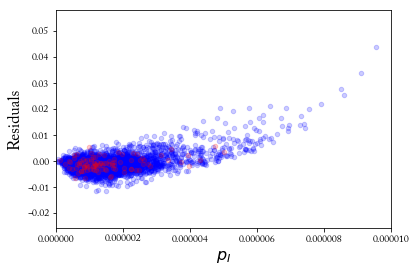

In [95]:
plt.scatter(regression_x_train, residuals, 
            c='b', s=20, alpha=0.2)
plt.scatter(regression_x_test, regr.predict(regression_x_test) - regression_y_test, 
            c='r', s=20, alpha=0.2)
plt.xlabel("$p_I$")
plt.ylabel("Residuals")

plt.xlim([0, 0.00001])

plt.show()

Some trend in the residuals (better prediction for small $p_I$), but not going into this here.

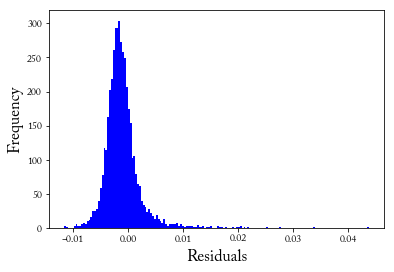

In [96]:
plt.hist(residuals, bins='auto', color="b", edgecolor=None)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [97]:
pd.Series(residuals).describe()

count    4375.000000
mean       -0.001128
std         0.003142
min        -0.011550
25%        -0.002791
50%        -0.001509
75%        -0.000010
max         0.043680
Name: prot_speed_per_transcript, dtype: float64

This means that the equation is in fact:

$$ r_\mathrm{synth} = 29140.9 \cdot p_I + 0.00314 \cdot \varepsilon $$

where $\varepsilon \sim N (0, 1)$.

I want to check whether the residuals can be explained by tAI (TODO).

### Is there a model for synthesis rates that would include the speed and hence the tAI? Or is $p_I$ enough in practice?

We model total time per protein as

$$ T = \alpha \cdot \frac{1}{p_I} + \beta \cdot \Delta t$$

In [98]:
regression_data['elongation rate [1/s]'] = 1 / regression_data['tic toc [s]']

In [99]:
regression_data['time per initiation [s]'] = 1 / regression_data['p_init']

Dependent variable for regression (time per protein per transcript):

In [100]:
regression_data['time per protein [s]'] = 1 / regression_data['prot_speed_per_transcript']

In [101]:
regression_data.head()

,name,tic toc [s],ORF length [nts],Speed,transcripts,prot_speeds,prot_speed_per_transcript,tAI,p_init,elongation rate [1/s],time per initiation [s],time per protein [s]
0,YBR177C,59.901247,1356,22.637258,6,0.311782,0.051964,0.394743,1.644214e-06,0.016694,6.081932e+05,19.244240
1,YIL140W,100.371746,2472,24.628445,2,0.099425,0.049713,0.387981,1.649229e-06,0.009963,6.063440e+05,20.115607
2,YLR268W,33.104739,645,19.483616,8,0.458934,0.057367,0.394340,1.844285e-06,0.030207,5.422156e+05,17.431684
3,YOR011W,214.940000,4185,19.470550,1,0.006322,0.006322,0.400647,2.686820e-07,0.004652,3.721872e+06,158.172727
4,YPL043W,75.186086,2058,27.372086,7,0.448563,0.064080,0.456066,2.096261e-06,0.013300,4.770397e+05,15.605381


In [102]:
dumpfile = open("../../parameters/regression_data_small.p", "wb")

In [103]:
pkl.dump(regression_data, dumpfile)

In [104]:
dumpfile.close()

In [105]:
preprocessing.scale(regression_data[['time per initiation [s]', 'tic toc [s]']])

array([[-0.299011  , -0.25714754],
       [-0.30044663,  0.55124425],
       [-0.35023291, -0.79240354],
       ...,
       [-0.43216354, -1.05543768],
       [-0.11668148,  0.50111691],
       [-0.59025246, -0.91647579]])

In [106]:
ntest = 100
regression_x = np.array([preprocessing.scale(regression_data['time per initiation [s]']),
                preprocessing.scale(regression_data['tic toc [s]'])]).reshape((len(regression_data), 2))

# Split the data into training/testing sets
regression_x_train = regression_x[:-ntest]
regression_x_test = regression_x[-ntest:]

# Split the targets into training/testing sets
regression_y_train = regression_data['time per protein [s]'][:-ntest]
regression_y_test = regression_data['time per protein [s]'][-ntest:]

In [107]:
regression_x

array([[-0.299011  , -0.30044663],
       [-0.35023291,  2.11830365],
       [-0.40083238, -0.25026433],
       ...,
       [ 2.07463306, -0.01778528],
       [-0.24147793, -1.05543768],
       [ 0.50111691, -0.91647579]])

In [108]:
# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(regression_x_train, regression_y_train)

# Make predictions using the testing set
regression_y_pred = regr.predict(regression_x_test)

# The coefficients
print 'Coefficients: ', regr.coef_
print 'Intercept: ', regr.intercept_

# The mean squared error
print "Mean squared error: %.2f" % mean_squared_error(regression_y_test, regression_y_pred)

# Explained variance score: 1 is perfect prediction
print 'R² score: %.2f' % r2_score(regression_y_test, regression_y_pred)

Coefficients:  [-0.33635352  0.18418834]
Intercept:  0.0
Mean squared error: 2284.83
R² score: -0.94


Not a good model - what went wrong? TODO

# Codon adaptation index (CAI)

Sharp and Li (Nucleic Acids Res. 1987 Feb 11;15(3):1281-95)

https://en.wikipedia.org/wiki/Codon_Adaptation_Index

CAI measures the deviation of a given protein coding gene sequence with respect to a reference set of genes.

CAI is simply defined as the geometric mean of the weight associated to each codon over the length of the gene sequence (measured in codons).

$$\text{CAI}=\exp \left( \frac{1}{L} \sum_{l=1}^L{\log \left(w_i(l)\right)}\right)$$

where $$w_i=\frac{f_i}{\max(f_j)} \qquad i,j \in [\text{synonymous codons for amino acid}]$$

In [109]:
import os.path
from Bio.SeqUtils.CodonUsage import CodonAdaptationIndex

In [110]:
CAI = CodonAdaptationIndex()

In [111]:
datadir = "../../data"
sequencefile = "orf_coding.fasta"
#sequencefile = "orf_coding_all.fasta" # not working (stops at a pseudogene fragment)
sequencefile = os.path.join(datadir, sequencefile)

In [112]:
CAI.generate_index(sequencefile)

In [113]:
handle = open(sequencefile, "rU")
record_dict = SeqIO.to_dict(SeqIO.parse(handle, "fasta"))
handle.close()
orf_genomic_dict = {key:str(record_dict[key].seq).lower().replace('t', 'u') for key in record_dict}

Generate a dictionary of all CAIs:

In [114]:
cai_dict = {}
for gene in orf_genomic_dict:
    orf_genomic_dict[gene] = orf_genomic_dict[gene].replace('u', 't')
    cai_dict[gene] = CAI.cai_for_gene(orf_genomic_dict[gene])

In [115]:
pkl.dump(cai_dict, open("../../parameters/cai_dict.p", "wb"))

Scatter CAI vs tAI:

5917


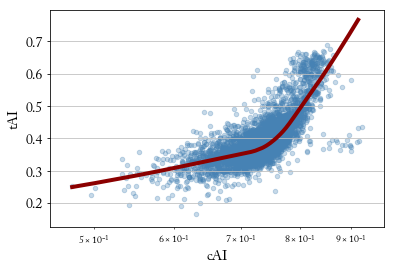

In [116]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(cai_dict, tAI_dict_python_chu, "cAI", "tAI",
              fontsize=14, alpha=0.3, xlog=True, ylog=False, xmax=False, ymax=False)

Scatter CAI vs tic_toc_speed_dict:

4475


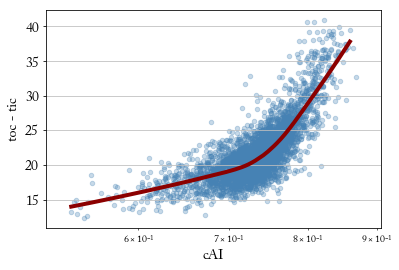

In [117]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(cai_dict, tic_toc_speed_dict, "cAI", "toc - tic",
              fontsize=14, alpha=0.3, xlog=True, ylog=False, xmax=False, ymax=False)

Not logarithmic:

4475


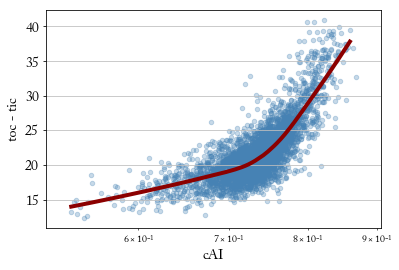

In [118]:
fig =  plt.figure()                
ax = fig.add_subplot(111)
scatter_dicts(cai_dict, tic_toc_speed_dict, "cAI", "toc - tic", 
              fontsize=14, alpha=0.3, xlog=True, ylog=False, xmax=False, ymax=False)

### tAI vs position on gene

Next we check tAI vs length (to test the ramp - beginning of gene should be slower, hence have lower translation efficiency, hence lower (?) tAI).

We need to take only ORFs longer than x and then take the first 30, 60, 90, 120 nts and calculate their tAI.

In [119]:
pd.Series(orf_lengths).describe()

count     6713.000000
mean      1352.414122
std       1139.682772
min         51.000000
25%        534.000000
50%       1077.000000
75%       1767.000000
max      14733.000000
dtype: float64

First we filter for only genes whose ORFs are at least (3 * 250 + 3) nts long. (We will cut away the start codon which is nearly constant.)

In [120]:
long_orfs = {gene: orfs[gene] for gene in orfs if len(orfs[gene]) >= 3 * 250 + 3}

In [121]:
len(long_orfs)

4330

Still lots of ORFs.

Hypothesis: "We describe a universally conserved translation efficiency profile that features low translation efficiency over the first ∼30–50 codons of mRNAs." (http://www.sciencedirect.com/science/article/pii/S0092867410003193)

We now calculate the tAI for the first, second,... , n-th ```width``` nts and average it across the long ORFs:

List of "regional" dicts:

We start with 30 codons (90 nts):

In [122]:
width = 90  # must be divisible by 3!!!
n = 4

In [123]:
start_regions_sliced_by_width = [{gene: long_orfs[gene][i * width + 3: (i + 1) * width + 3] for gene in long_orfs} 
                                 for i in range(n)]

In [124]:
print len(start_regions_sliced_by_width)
print len(start_regions_sliced_by_width[0])

4
4330


tAI calculation ([see above](#tai_python)):

In [125]:
tai_2 = tAI.tAI(trna_count=codon_tRNA_abundancy_series, bacteria=False)

In [126]:
xs = []
ys = []

for i in range(n):
    xs.append((i + 0.5) * width + 3)
    ys.append(np.average([tai_2.calc(start_regions_sliced_by_width[i][gene]) 
                         for gene in start_regions_sliced_by_width[i] 
                         if not np.isnan(tai_2.calc(start_regions_sliced_by_width[i][gene]))]))
print xs
print ys

[48.0, 138.0, 228.0, 318.0]
[0.36852887215255403, 0.3784859837300089, 0.3827646559884893, 0.3829216042235709]


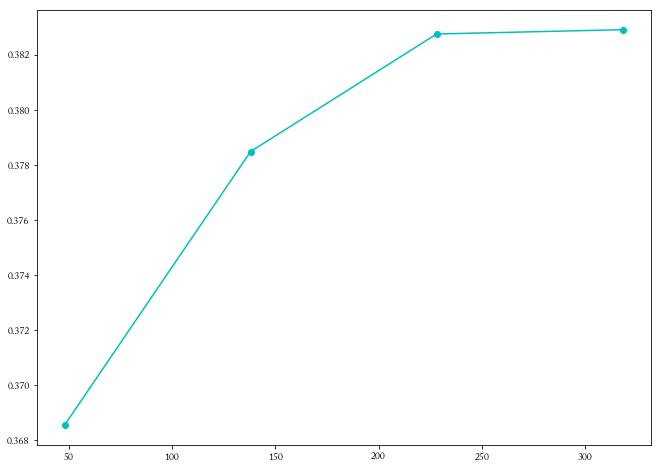

In [127]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.plot(xs, ys, label='tAI for 90 nt buckets', color='c', marker='o')

Next we try 50 codons (150 nts):

In [128]:
width = 150  # must be divisible by 3!!!
n = 4

In [129]:
start_regions_sliced_by_width = [{gene: long_orfs[gene][i * width + 3: (i + 1) * width + 3] for gene in long_orfs} 
                                 for i in range(n)]

In [130]:
print len(start_regions_sliced_by_width)
print len(start_regions_sliced_by_width[0])

4
4330


tAI calculation ([see above](#tai_python)):

In [131]:
tai_2 = tAI.tAI(trna_count=codon_tRNA_abundancy_series, bacteria=False)

In [132]:
xs = []
ys = []

for i in range(n):
    xs.append((i + 0.5) * width + 3)
    ys.append(np.average([tai_2.calc(start_regions_sliced_by_width[i][gene]) 
                         for gene in start_regions_sliced_by_width[i] 
                         if not np.isnan(tai_2.calc(start_regions_sliced_by_width[i][gene]))]))
print xs
print ys

[78.0, 228.0, 378.0, 528.0]
[0.3699765094002027, 0.3804158669090248, 0.38314886950326127, 0.3889532102008616]


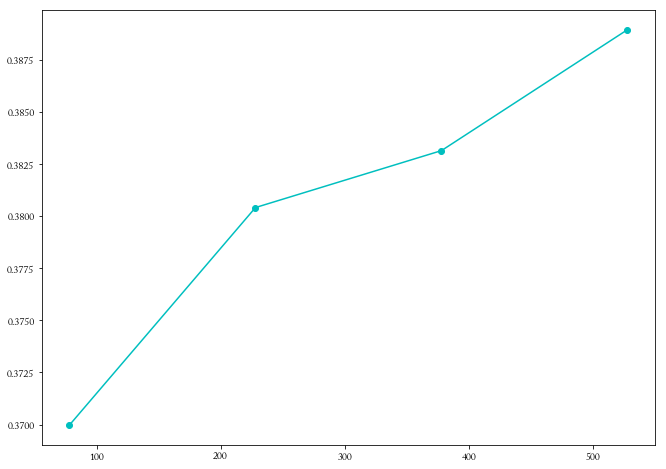

In [133]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.plot(xs, ys, label='tAI for 150 nt buckets', color='c', marker='o')

In [134]:
myedgecolor = 'steelblue'
myfacecolor = 'powderblue'

4716
4716


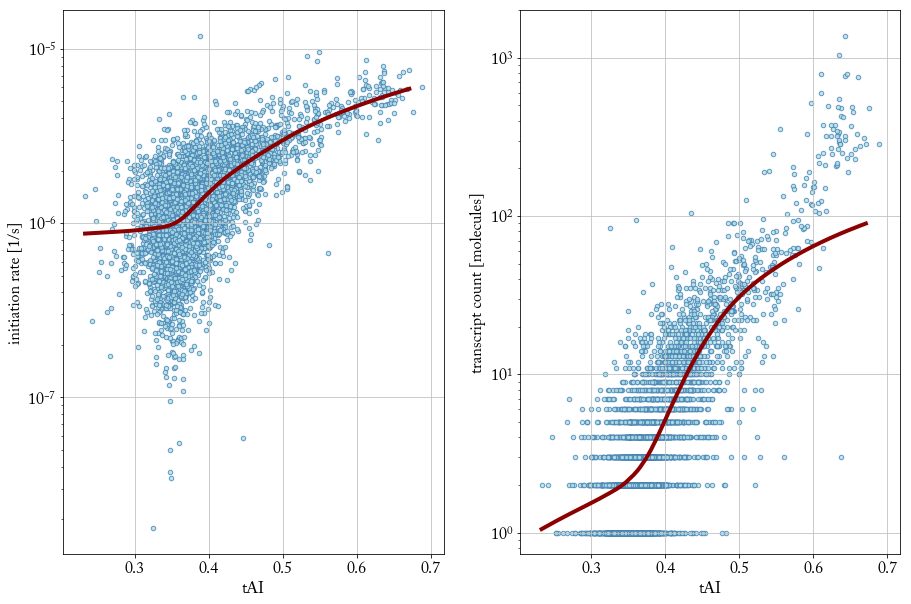

In [135]:
fig =  plt.figure(figsize=(15, 10))          

ax = fig.add_subplot(1, 2, 1)
scatter_dicts(tAI_dict_python_chu, initiation_rates, xaxislabel="tAI", yaxislabel="initiation rate [1/s]", fontsize=16, 
              markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=False, rasterized=True)

ax = fig.add_subplot(1, 2, 2)
scatter_dicts(tAI_dict_python_chu, transcriptome, xaxislabel="tAI", yaxislabel="transcript count [molecules]", 
              fontsize=16, markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=False, rasterized=True)


plt.savefig('tAI_vs_parameters.pgf', bbox_inches='tight', dpi=200)

4716
4716


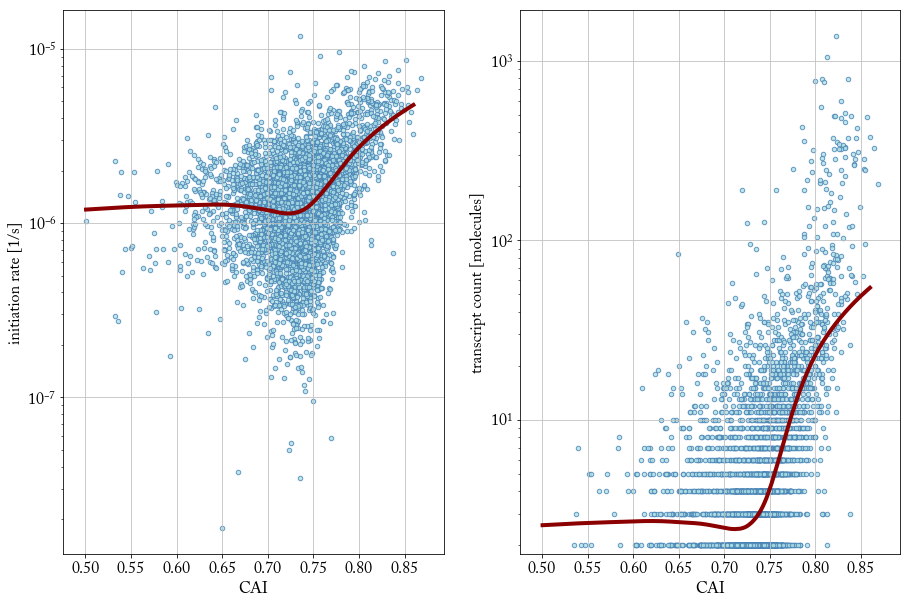

In [136]:
fig =  plt.figure(figsize=(15, 10))          

ax = fig.add_subplot(1, 2, 1)
scatter_dicts(cai_dict, initiation_rates, xaxislabel="CAI", yaxislabel="initiation rate [1/s]", fontsize=16, 
              markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=False, rasterized=True)

ax = fig.add_subplot(1, 2, 2)
scatter_dicts(cai_dict, transcriptome, xaxislabel="CAI", yaxislabel="transcript count [molecules]", 
              fontsize=16, markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=False, rasterized=True)


plt.savefig('CAI_vs_parameters.pgf', bbox_inches='tight', dpi=200)

4716
4716
4716
4716


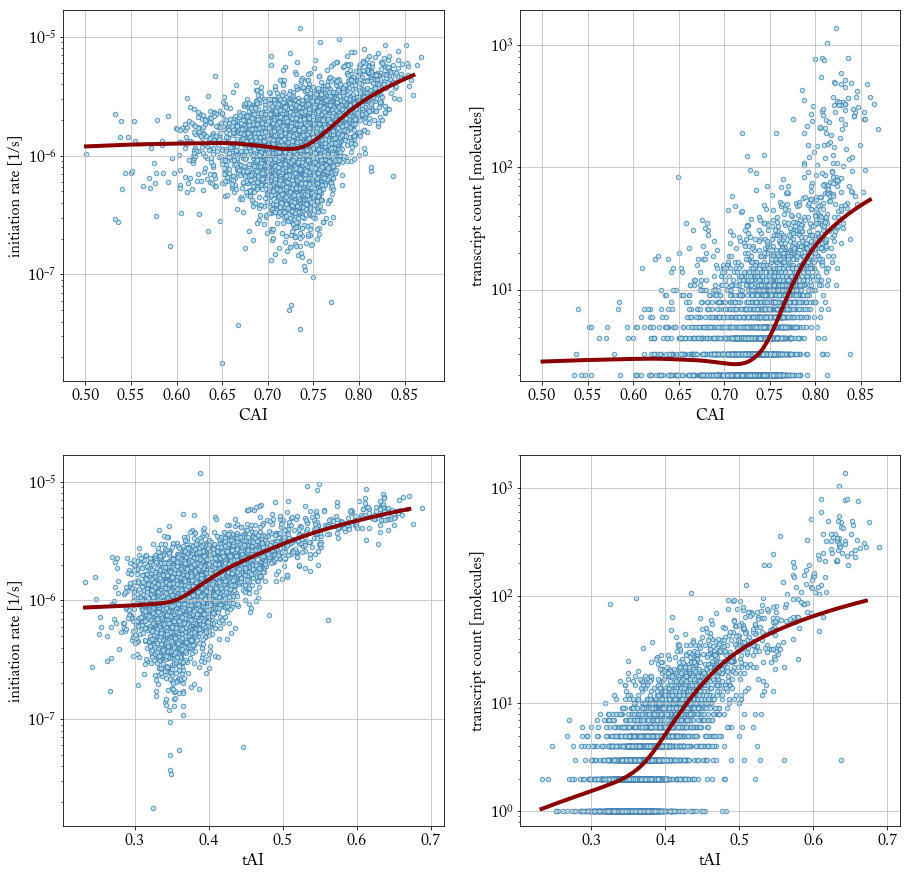

In [137]:
fig =  plt.figure(figsize=(15, 15))          

ax = fig.add_subplot(2, 2, 1)
scatter_dicts(cai_dict, initiation_rates, xaxislabel="CAI", yaxislabel="initiation rate [1/s]", fontsize=16, 
              markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=False, rasterized=True)

ax = fig.add_subplot(2, 2, 2)
scatter_dicts(cai_dict, transcriptome, xaxislabel="CAI", yaxislabel="transcript count [molecules]", 
              fontsize=16, markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=False, rasterized=True)

ax = fig.add_subplot(2, 2, 3)
scatter_dicts(tAI_dict_python_chu, initiation_rates, xaxislabel="tAI", yaxislabel="initiation rate [1/s]", fontsize=16, 
              markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=False, rasterized=True)

ax = fig.add_subplot(2, 2, 4)
scatter_dicts(tAI_dict_python_chu, transcriptome, xaxislabel="tAI", yaxislabel="transcript count [molecules]", 
              fontsize=16, markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=False, rasterized=True)


plt.savefig('CAI_tAI_vs_parameters.pgf', bbox_inches='tight', dpi=200)

4475
4475


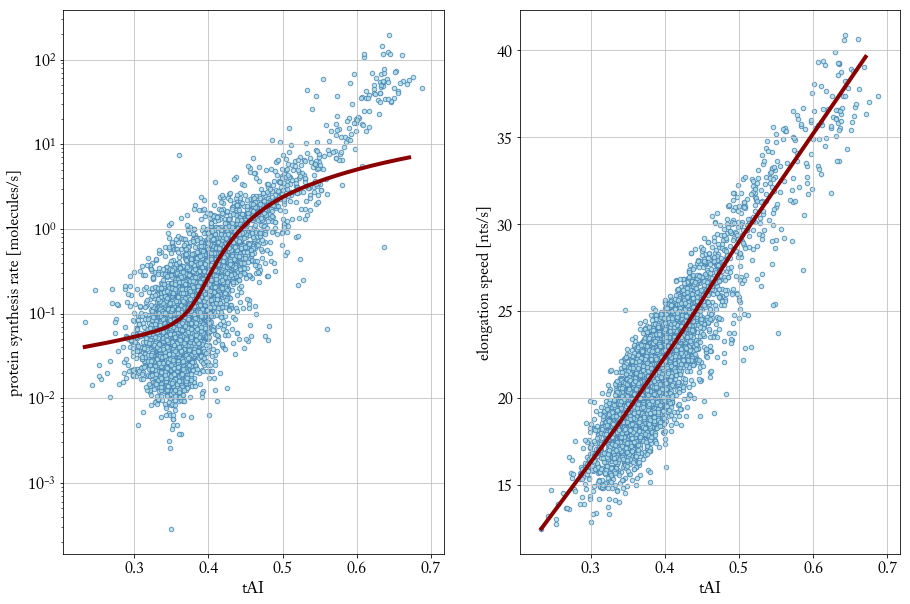

In [138]:
fig =  plt.figure(figsize=(15, 10))          

ax = fig.add_subplot(1, 2, 1)
scatter_dicts(tAI_dict_python_chu, prot_speeds, xaxislabel="tAI", yaxislabel="protein synthesis rate [molecules/s]", fontsize=16, 
              markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=False, rasterized=True)

ax = fig.add_subplot(1, 2, 2)
scatter_dicts(tAI_dict_python_chu, tic_toc_speed_dict, xaxislabel="tAI", yaxislabel="elongation speed [nts/s]", 
              fontsize=16, markersize=20, alpha=0.8, xlog=False, ylog=False, xmax=False, ymax=False, rasterized=True)


plt.savefig('tAI_vs_speed.pgf', bbox_inches='tight', dpi=200)

4475
4475


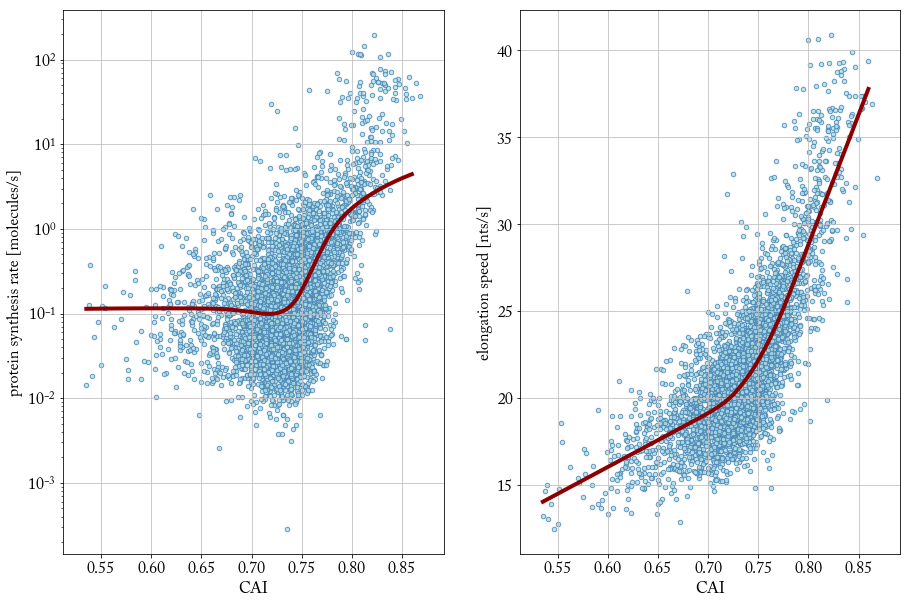

In [139]:
fig =  plt.figure(figsize=(15, 10))          

ax = fig.add_subplot(1, 2, 1)
scatter_dicts(cai_dict, prot_speeds, xaxislabel="CAI", yaxislabel="protein synthesis rate [molecules/s]", fontsize=16, 
              markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=False, rasterized=True)

ax = fig.add_subplot(1, 2, 2)
scatter_dicts(cai_dict, tic_toc_speed_dict, xaxislabel="CAI", yaxislabel="elongation speed [nts/s]", 
              fontsize=16, markersize=20, alpha=0.8, xlog=False, ylog=False, xmax=False, ymax=False, rasterized=True)


plt.savefig('CAI_vs_speed.pgf', bbox_inches='tight', dpi=200)

4475
4475
4475
4475


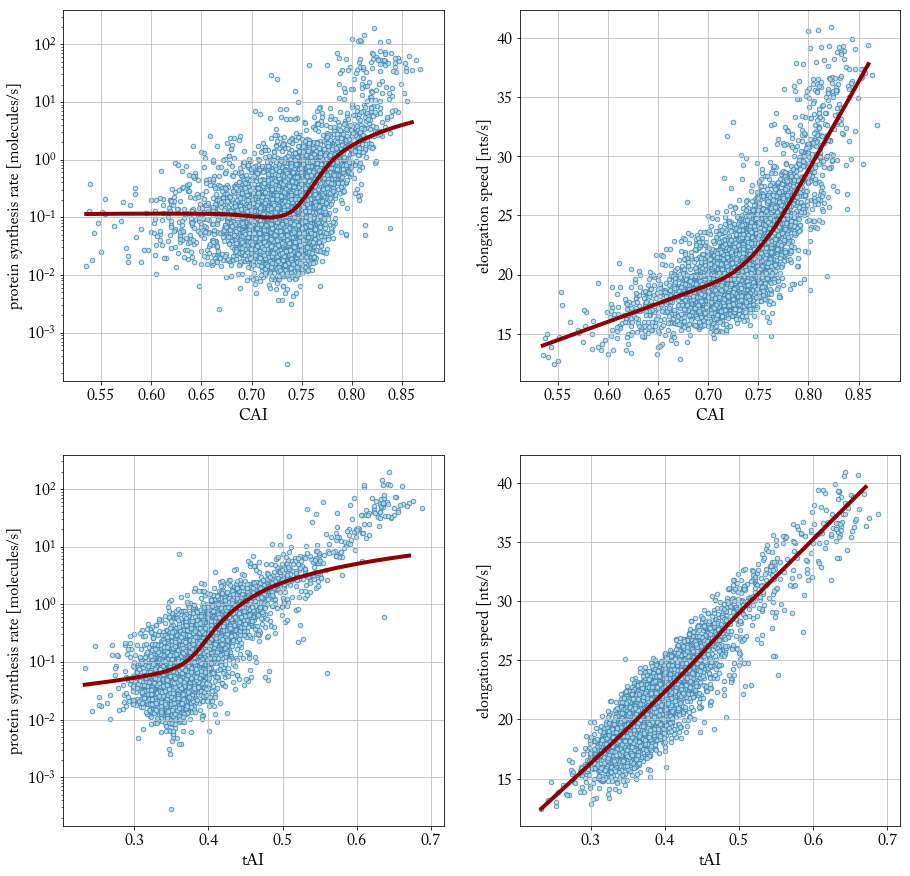

In [140]:
fig =  plt.figure(figsize=(15, 15))          

ax = fig.add_subplot(2, 2, 1)
scatter_dicts(cai_dict, prot_speeds, xaxislabel="CAI", yaxislabel="protein synthesis rate [molecules/s]", fontsize=16, 
              markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=False, rasterized=True)

ax = fig.add_subplot(2, 2, 2)
scatter_dicts(cai_dict, tic_toc_speed_dict, xaxislabel="CAI", yaxislabel="elongation speed [nts/s]", 
              fontsize=16, markersize=20, alpha=0.8, xlog=False, ylog=False, xmax=False, ymax=False, rasterized=True)

ax = fig.add_subplot(2, 2, 3)
scatter_dicts(tAI_dict_python_chu, prot_speeds, xaxislabel="tAI", yaxislabel="protein synthesis rate [molecules/s]", fontsize=16, 
              markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=False, rasterized=True)

ax = fig.add_subplot(2, 2, 4)
scatter_dicts(tAI_dict_python_chu, tic_toc_speed_dict, xaxislabel="tAI", yaxislabel="elongation speed [nts/s]", 
              fontsize=16, markersize=20, alpha=0.8, xlog=False, ylog=False, xmax=False, ymax=False, rasterized=True)


plt.savefig('CAI_tAI_vs_speed.pgf', bbox_inches='tight', dpi=200)

### Plot against Arava et al. data  (http://www.pnas.org/content/100/7/3889.full):

In [141]:
prot_exp = pkl.load(open("../../parameters/prot_arava.p"))
prot_exp = {gene: prot_exp[gene] for gene in prot_exp if prot_exp[gene] > 1e-16}

In [151]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None, markersize=20,
                  alpha=0.8, xlog=True, ylog=True, xmax=False, ymax=False, xmin=False, ymin=False, rasterized=True):
    #, filename="scatterdict.png"):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    #fig =  plt.figure(figsize=figsize)                

    #ax = fig.add_subplot(111)
    #ax.set_rasterization_zorder(1)
    
    ax.grid(True, linestyle = '-', color = '0.75')
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    if xmax:
        ax.set_xlim(right=xmax)
    if ymax:
        ax.set_ylim(top=ymax)
    if xmin:
        ax.set_xlim(left=xmin)
    if ymin:
        ax.set_ylim(bottom=ymin)

    scat = plt.scatter(xs, ys,
                       #c=plt.rcParams['axes.color_cycle'][0], 
                       c=myfacecolor, 
                       #edgecolor=plt.rcParams['patch.edgecolor'],
                       edgecolor=myedgecolor,
                       s=markersize, zorder=0)
    scat.set_alpha(alpha)
    #scat.set_color()
    #scat.set_edgecolors(plt.rcParams['patch.edgecolor'])
    # , color=, edgecolor=

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points][:-2]  # modify to remove outliers 
    new_ys = [point[1] for point in sorted_points][:-2]  # modify to remove outliers
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, 'darkred', linewidth=4)

    ax.set_rasterization_zorder(1)

5165
5610


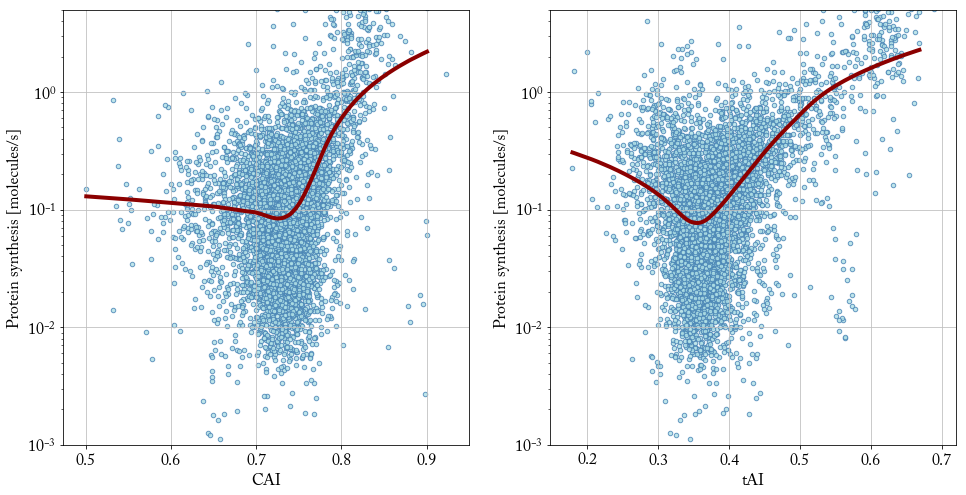

In [160]:
fig =  plt.figure(figsize=(16, 8))          

ax = fig.add_subplot(1, 2, 1)

scatter_dicts(cai_dict, prot_exp, xaxislabel="CAI", yaxislabel="Protein synthesis [molecules/s]", fontsize=16, 
              markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=5, xmin=False, ymin=1e-3, 
              rasterized=True)

ax = fig.add_subplot(1, 2, 2)

scatter_dicts(tAI_dict_python_chu, prot_exp, xaxislabel="tAI", yaxislabel="Protein synthesis [molecules/s]", 
              fontsize=16, markersize=20, alpha=0.8, xlog=False, ylog=True, xmax=False, ymax=5, xmin=False, 
              ymin=1e-3, rasterized=True)

plt.savefig('CAI_tAI_vs_Arava.pgf', bbox_inches='tight', dpi=200)